In this notebook I will extract the density of the functional group that might be in the active layer.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
import warnings


import inverse_method_funs as inv
import sb_tools

%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

# Read scattering models
Import species backscattering cross section matrix

In [3]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'

specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

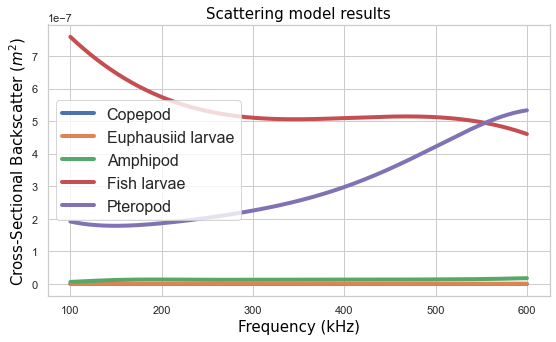

In [4]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Resample to line up output and input

In [5]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')

sv_all = np.zeros((1001,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))

In [6]:
len(freqs_EV)

1001

In [7]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])
ci_boot0 = np.zeros([len(freqs_EV),len(specs)])
ci_boot1 = np.zeros([len(freqs_EV),len(specs)])


for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])
    ci_boot0[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[0,:,ind_spec])
    ci_boot1[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[1,:,ind_spec])

In [8]:
np.shape(sigbs_mean)

(1001, 5)

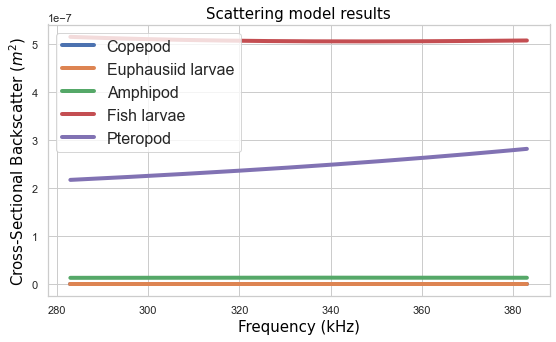

In [9]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigbs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

Text(0.5, 0, 'Frequency (kHz)')

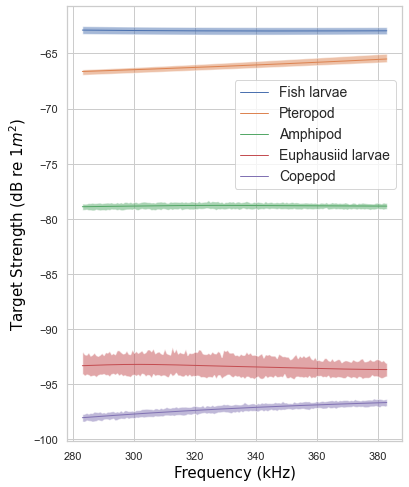

In [10]:
fig=plt.figure(figsize=(6, 8),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in [3,4,2,1,0]:
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(sigbs_mean[:,ind]) - (10*(0.434*(sigbs_mean[:,ind]-ci_boot0[:,ind])/sigbs_mean[:,ind]))
    logci_1 = 10*np.log10(sigbs_mean[:,ind]) + 10*(0.434*(ci_boot1[:,ind]-sigbs_mean[:,ind])/sigbs_mean[:,ind])
    
    plt.plot(freqs_EV[:],10*np.log10(sigbs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],logci_0,logci_1, alpha=0.5)
    
plt.legend(fontsize=14, loc=(0.5,0.58))
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
#plt.title('Scattering model results', title_font);

In [59]:
np.min(10*np.log10(sigbs_mean[:,-2]))

-62.958837142210285

# Inverse method
Calculate mean predicted density for each active layer

# Read wideband frequency response
Read the Echoview export of wideband frequency response. sv pulse compressed.

- For each file export 1 estimate with error bars. (August 18th)

In [11]:
fname_EV;

And Run a least squares solver

In [12]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')
nfiles = len(fname_EV)

sv_all = np.zeros((len(freqs_EV), nfiles))
sv_all_sd = np.zeros((len(freqs_EV), nfiles))
times = np.zeros((0))
density = np.zeros((5, nfiles))
sigbs = sigbs_mean
for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
    times = np.append(times, times_out[0])
    
    # Calculate optimate density combination for each sv(f) export then take the mean of the results
    #density_out = np.zeros([np.shape(sigbs_mean)[1], np.shape(sv_out)[1]])
    #for sv_ind in np.arange(np.shape(sv_out)[1]):
    #    d = optimize.lsq_linear(sigbs, sv_out[:,sv_ind], bounds=(0,np.inf))
    #    density_out[:,sv_ind] =  d.x


    #density_mean[:,ind] = np.mean(density_out,1)
    
    # Calculate the mean of the sv(f) across the SSL and optimize the density estimates based on the average.
    sv_median = np.median(sv_out,1)
    sv_sd = np.std(sv_out,1)
    d = optimize.lsq_linear(sigbs, sv_median, bounds=(0,np.inf))
    density[:,ind] =  d.x
    
    #keep all sv_median and sv_sd
    sv_all[:,ind] = sv_median
    sv_all_sd[:,ind] = sv_sd


In [13]:
np.shape(sv_all)

(1001, 67)

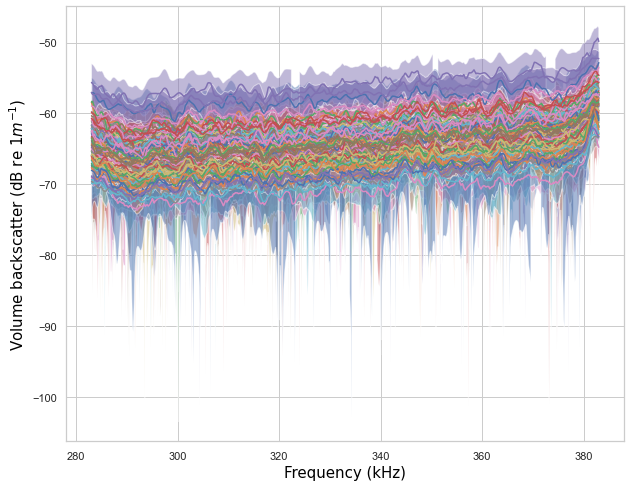

In [14]:
plt.figure(figsize=(10,8))

for ind in range(nfiles):
    plt.plot(freqs_EV, 10*np.log10(sv_all[:,ind]));
    plt.fill_between(freqs_EV[:],10*np.log10(sv_all[:,ind]-sv_all_sd[:,ind]), 10*np.log10(sv_all[:,ind]+sv_all_sd[:,ind]), alpha=0.5);
    plt.ylabel('Volume backscatter (dB re $1m^{-1}$)', axis_font)
    plt.xlabel('Frequency (kHz)', axis_font)

I calculate mean sv(f) from across SSL then calculate optimate density of each taxa. Reduces dependance on variability in each ping sv(f).

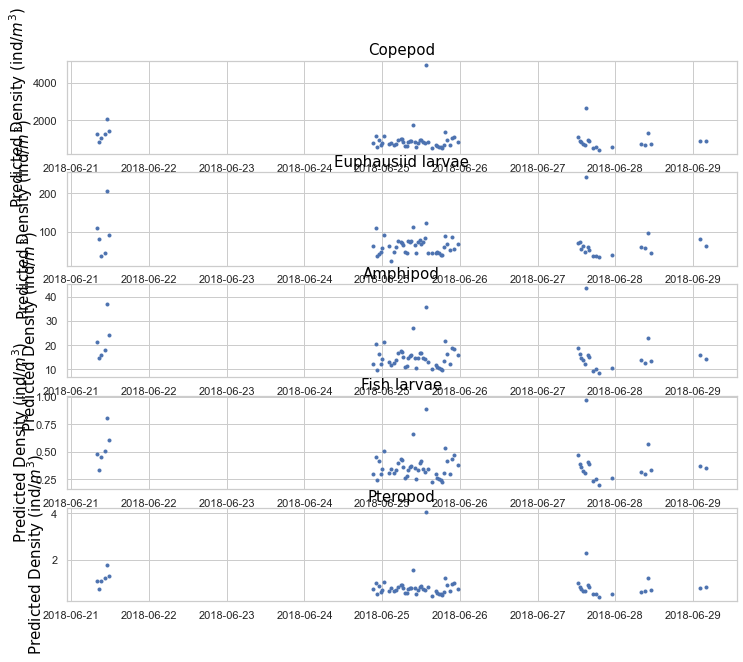

In [15]:
plt.figure(figsize=(12, 12),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(len(specs)+1,1,ind+1)
    plt.plot(times, density[ind,:], '.')
    #plt.plot(times, density_mean[ind,:], '.k')
    plt.title(specs[ind], title_font)
    plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)

## Load lat/lon

In [16]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [17]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [18]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [19]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(len(times)):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'Acoustics'}, 
                            'ignore_index=True')

## Add net data

In [20]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [21]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,18):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

In [22]:
## Add log of data as column
data['log_density']=np.log10(data.density+1)
data['log_density'][np.isnan(data['log_density'])]==0


Series([], Name: log_density, dtype: bool)

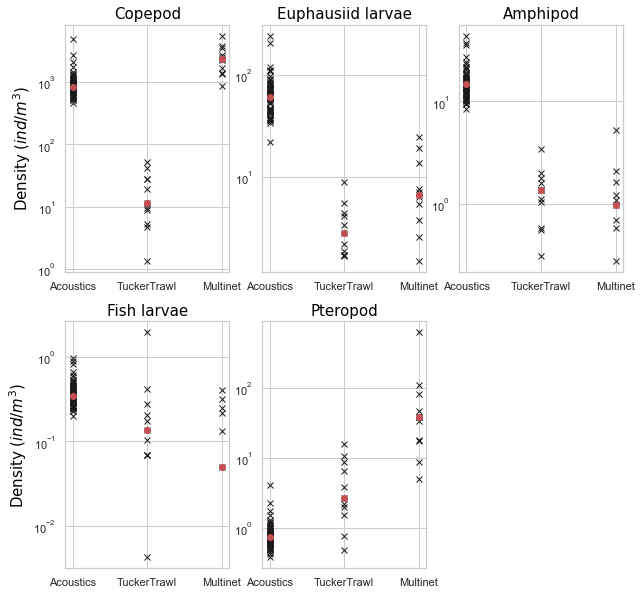

In [60]:
fig = plt.figure(figsize=(10,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    ax.semilogy(data.source[data.species==specs[ind_spec]],data.density[data.species==specs[ind_spec]], 'kx')
    ax.semilogy(data[data.species==specs[ind_spec]].groupby('source').median().index,data[data.species==specs[ind_spec]].groupby('source').median()['density'], 'r.', markersize=12)
    ax.set_title(specs[ind_spec], title_font)
    if ind_spec==0:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);


In [24]:
len(data.density[data.source=='TuckerTrawl'])/5

11.0

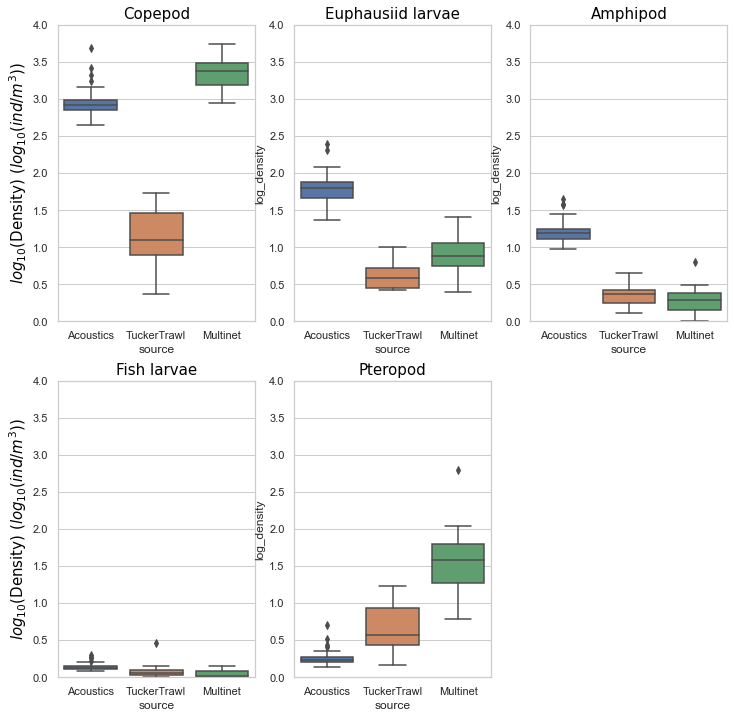

In [25]:
fig = plt.figure(figsize=(12,12))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);

# Set up per species data

In [26]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'Acoustic'}, 
                            'ignore_index=True')

In [27]:
#Dataframe with all species
for stn_ind in range(7,18):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

In [28]:
data_spec

,lat,lon,datetime,Copepod,Euphausiid larvae,Amphipod,Fish larvae,Pteropod,source
0,70.826248,18.004681,2018-06-21 11:01:13,2100.273984,206.071834,37.254845,0.810018,1.749996,Acoustic
1,70.825203,18.006540,2018-06-21 11:31:11,1447.934771,90.943172,24.342725,0.610264,1.289192,Acoustic
2,70.832222,18.017429,2018-06-21 08:01:08,1280.011640,110.116758,21.406949,0.484028,1.087544,Acoustic
3,70.832222,18.017429,2018-06-21 08:37:04,829.311090,81.333738,14.832906,0.332224,0.704859,Acoustic
4,70.832222,18.017429,2018-06-21 09:01:10,1055.348343,36.964778,15.744839,0.455763,1.048258,Acoustic
...,...,...,...,...,...,...,...,...,...
84,70.525000,18.166000,2018-06-24 10:57:00,1348.308571,7.158357,1.210071,0.000000,81.275643,Multinet
85,70.500000,16.936000,2018-06-25 05:35:00,11.598706,4.453074,0.586839,0.172600,3.866235,TuckerTrawl
86,70.500000,16.936000,2018-06-25 05:35:00,1671.828571,1.509524,0.280000,0.000000,8.742857,Multinet
87,70.493000,17.636000,2018-06-25 20:26:00,1.380798,2.813376,0.310680,0.069040,0.483279,TuckerTrawl


In [29]:
sum(data['source']=='Multinet')/5

11.0

In [30]:
# Send to R
data.to_feather('.\SSL_density.feather')
data_spec.to_feather('.\SSL_density_spec.feather')

# Compare abundance maps

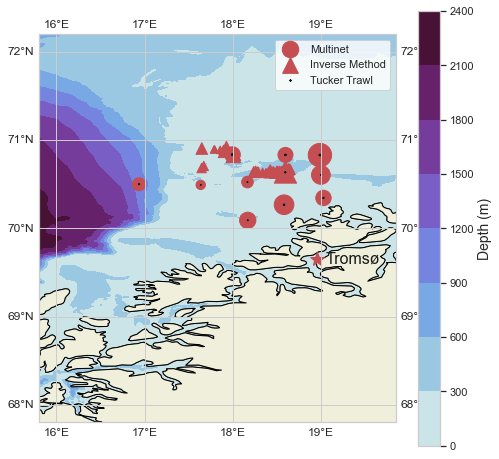

In [31]:
fname_topo = "C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/NordNorgeTopo_tromsoflaket.xlsx"

fig = plt.figure(figsize=(8,8))
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
data_MT = data[data.source=='Multinet']
plt.scatter(data_MT.lon,data_MT.lat,data_MT.density/10,'r', marker='o', label='Multinet')
data_imm = data[data.source=='Acoustics']
plt.scatter(data_imm.lon,data_imm.lat,data_imm.density/10, 'r', marker='^', label='Inverse Method')
data_TT = data[data.source=='TuckerTrawl']
plt.scatter(data_TT.lon,data_TT.lat,data_TT.density/10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

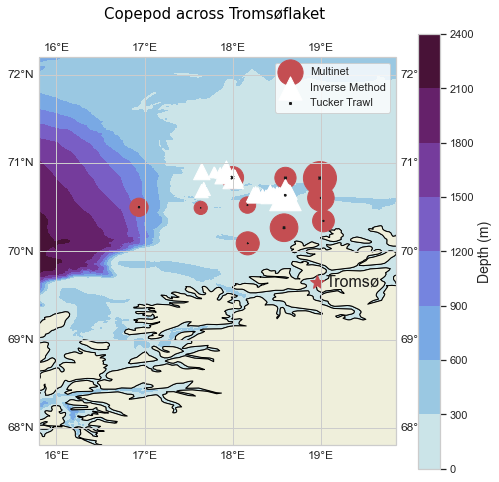

In [32]:
spec = 'Copepod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))

ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.title('%s across Tromsøflaket \n' %spec, title_font)
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density/5,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density/5, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density/5, 'k', marker='x', label='Tucker Trawl')
plt.legend()

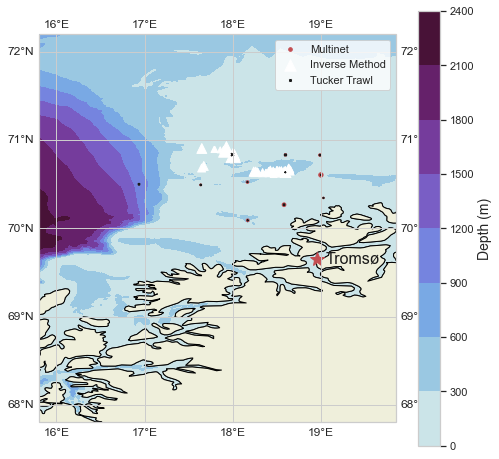

In [33]:
spec = 'Euphausiid larvae'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

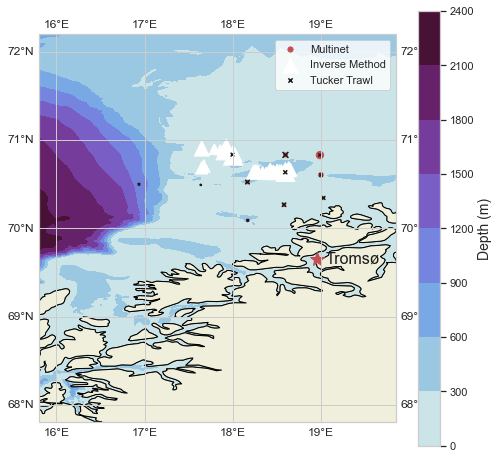

In [34]:
spec = 'Amphipod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*10,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*10, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

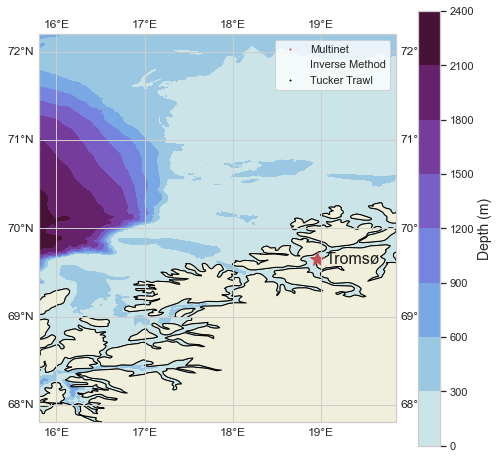

In [35]:
spec = 'FishLarvae'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*100,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*100, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*100, 'k', marker='x', label='Tucker Trawl')
plt.legend()

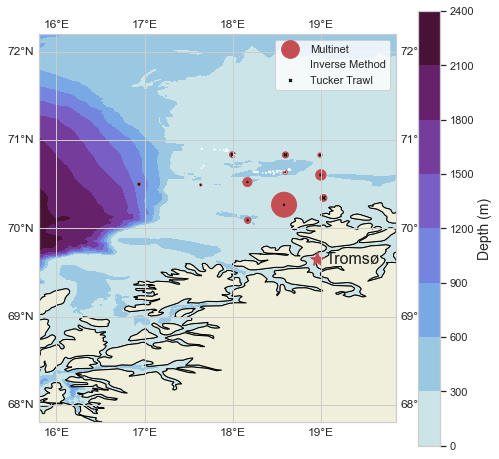

In [36]:
spec = 'Pteropod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

# Plot relative abundance comparison

In [37]:
data_imm.groupby('species').std()

,lat,lon,density,log_density
species,,,,
Amphipod,0.109481,0.323075,6.316849,0.131867
Copepod,0.109481,0.323075,612.717523,0.169038
Euphausiid larvae,0.109481,0.323075,35.071373,0.174928
Fish larvae,0.109481,0.323075,0.144782,0.041672
Pteropod,0.109481,0.323075,0.505510,0.086537


In [38]:
mean_rel_abundance_imm = data_imm.groupby('species').mean()/sum(data_imm.groupby('species').mean()['density'])
mean_rel_abundance_MT = data_MT.groupby('species').mean()/sum(data_MT.groupby('species').mean()['density'])
mean_rel_abundance_TT = data_TT.groupby('species').mean()/sum(data_TT.groupby('species').mean()['density'])
std_rel_abundance_imm = data_imm.groupby('species')['density'].std()/sum(data_imm.groupby('species').mean()['density'])
std_rel_abundance_MT = data_MT.groupby('species')['density'].std()/sum(data_MT.groupby('species').mean()['density'])
std_rel_abundance_TT = data_TT.groupby('species')['density'].std()/sum(data_TT.groupby('species').mean()['density'])

In [39]:
std_rel_abundance_imm

species
Amphipod             0.006012
Copepod              0.583179
Euphausiid larvae    0.033381
Fish larvae          0.000138
Pteropod             0.000481
Name: density, dtype: float64

Text(0, 0.5, 'Relative abundance')

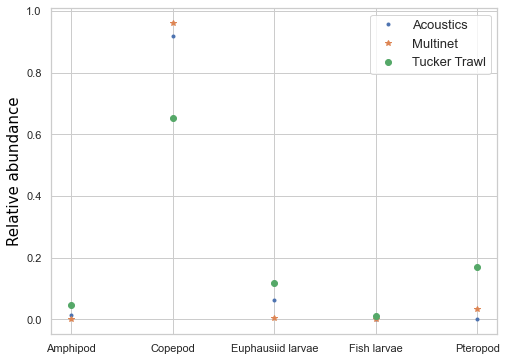

In [40]:
plt.figure(figsize=(8,6))
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_imm['density'], '.', label='Acoustics')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_MT['density'], '*', label='Multinet')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_TT['density'], 'o',label='Tucker Trawl')
plt.legend(fontsize=13)
#plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

Text(0, 0.5, 'Relative abundance')

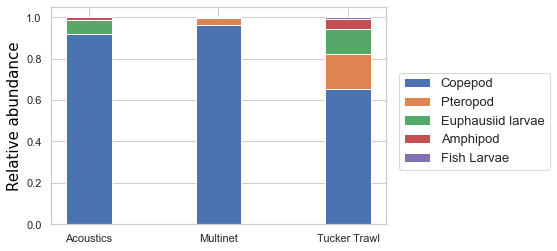

In [41]:
labels = ['Acoustics', 'Multinet','Tucker Trawl']
copepod = np.array([mean_rel_abundance_imm['density'][1], mean_rel_abundance_MT['density'][1], mean_rel_abundance_TT['density'][1]])
pteropod = np.array([mean_rel_abundance_imm['density'][4], mean_rel_abundance_MT['density'][4], mean_rel_abundance_TT['density'][4]])
fishlarvae = np.array([mean_rel_abundance_imm['density'][3], mean_rel_abundance_MT['density'][3], mean_rel_abundance_TT['density'][3]])
amphipod = np.array([mean_rel_abundance_imm['density'][0], mean_rel_abundance_MT['density'][0], mean_rel_abundance_TT['density'][0]])
krill = np.array([mean_rel_abundance_imm['density'][2], mean_rel_abundance_MT['density'][2], mean_rel_abundance_TT['density'][2]])
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, copepod, width, label='Copepod')
ax.bar(labels, pteropod, width, bottom=copepod, label='Pteropod')
ax.bar(labels, krill, width, bottom=copepod+pteropod, label='Euphausiid larvae')
ax.bar(labels, amphipod, width, bottom=copepod+pteropod+krill, label='Amphipod')
ax.bar(labels, fishlarvae, width, bottom=copepod+pteropod+krill+amphipod, label='Fish Larvae')

plt.legend(loc=(1.04, 0.25), fontsize=13)
#plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

Text(0, 0.5, 'Relative abundance')

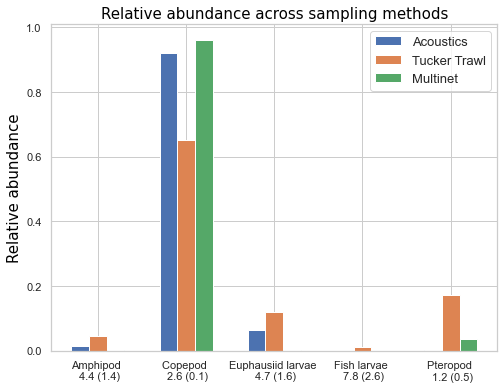

In [42]:
width=0.2
ind = np.arange(5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.bar(ind, mean_rel_abundance_imm['density'], width, label='Acoustics')
ax.bar(ind+width, mean_rel_abundance_TT['density'], width, label='Tucker Trawl')
ax.bar(ind+width+width, mean_rel_abundance_MT['density'], width, label='Multinet')

ax.set_xticks(ind + (2*width) / 2)
ax.set_xticklabels(['Amphipod \n 4.4 (1.4)', 'Copepod \n 2.6 (0.1)', 'Euphausiid larvae \n 4.7 (1.6)', 'Fish larvae \n 7.8 (2.6)', 'Pteropod \n 1.2 (0.5)'] )
plt.legend(loc='upper right', fontsize=13)
plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

In [43]:
mean_rel_abundance_imm

,lat,lon,density,log_density
species,,,,
Amphipod,0.067313,0.017375,0.015094,0.001147
Copepod,0.067313,0.017375,0.919708,0.002802
Euphausiid larvae,0.067313,0.017375,0.064026,0.001709
Fish larvae,0.067313,0.017375,0.000368,0.000133
Pteropod,0.067313,0.017375,0.000804,0.000243


In [44]:
data_imm.groupby('species').mean()['density']

species
Amphipod              15.858929
Copepod              966.292728
Euphausiid larvae     67.268904
Fish larvae            0.386228
Pteropod               0.844368
Name: density, dtype: float64

In [45]:
data_MT.groupby('species').mean()['density']

species
Amphipod                1.260909
Copepod              2534.240057
Euphausiid larvae       8.986724
Fish larvae             0.123810
Pteropod               92.539937
Name: density, dtype: float64

In [46]:
np.mean(data_imm[data_imm['species']=='Krill']['density'])


nan

In [47]:
data[data.species=='Krill'].groupby('source').mean()['density']

Series([], Name: density, dtype: float64)

In [48]:
mean_rel_abundance_imm['density']

species
Amphipod             0.015094
Copepod              0.919708
Euphausiid larvae    0.064026
Fish larvae          0.000368
Pteropod             0.000804
Name: density, dtype: float64

In [49]:
mean_rel_abundance_TT['density']

species
Amphipod             0.046676
Copepod              0.653150
Euphausiid larvae    0.118335
Fish larvae          0.010622
Pteropod             0.171217
Name: density, dtype: float64

In [50]:
mean_rel_abundance_MT['density']

species
Amphipod             0.000478
Copepod              0.960976
Euphausiid larvae    0.003408
Fish larvae          0.000047
Pteropod             0.035091
Name: density, dtype: float64

# Size distributions

### Total length distributions acoustics

In [51]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# For gamma distirbution scale = 1/rate. alpha = shape.
# For log normal distribution. s=sigma(logstd), scale=e^(mu or logmean)

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist = stats.gamma.pdf(x, a=5.4,scale=1/4.6) #Full length not radius
cope_dist = stats.gamma.pdf(x, a=7.0, scale=1/4) # 
amphi_dist = stats.gamma.pdf(x, a=10.3, scale=1/2.3)
euphau_dist = stats.lognorm.pdf(x, s=0.3, scale=np.exp(1.5))
fish_dist = stats.lognorm.pdf(x, s=0.28, scale = np.exp(2.02)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Total length distibutions tucker

In [52]:

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist_tuck = stats.gamma.pdf(x, a=17.5,scale=1/14.1) #Full length not radius
cope_dist_tuck = stats.gamma.pdf(x, a=7.0, scale=1/4)
amphi_dist_tuck = stats.gamma.pdf(x, a=10.9, scale=1/2.5)
euphau_dist_tuck = stats.lognorm.pdf(x, s=0.3, scale=np.exp(1.5)) # Same as acoustic
fish_dist_tuck = stats.lognorm.pdf(x, s=0.31, scale = np.exp(2.18)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Total length distributions mulitnet

In [53]:

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist_multi = stats.gamma.pdf(x, a=5.6,scale=1/3.8) #Full length not radius
cope_dist_multi = stats.norm.pdf(x, loc=2.62, scale=0.09)
amphi_dist_multi = stats.gamma.pdf(x, a=9.8, scale=1/2.1)
euphau_dist_multi = stats.gamma.pdf(x, a=14.7, scale=1/2.01)
fish_dist_multi = stats.lognorm.pdf(x, s=0.48, scale = np.exp(1.97)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Plot distributions

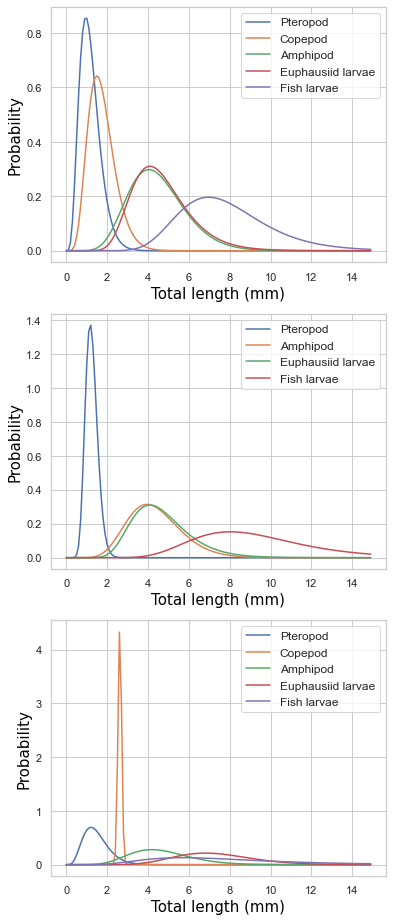

In [54]:
plt.figure(figsize=(6,16))
ax = plt.subplot(3,1,1)
plt.plot(x, lima_dist, label='Pteropod')
plt.plot(x, cope_dist, label='Copepod')
plt.plot(x, amphi_dist, label='Amphipod')
plt.plot(x, euphau_dist, label='Euphausiid larvae')
plt.plot(x, fish_dist, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

ax = plt.subplot(3,1,2)
plt.plot(x, lima_dist_tuck, label='Pteropod')
#plt.plot(x, cope_dist_tuck, label='Copepod')
plt.plot(x, amphi_dist_tuck, label='Amphipod')
plt.plot(x, euphau_dist_tuck, label='Euphausiid larvae')
plt.plot(x, fish_dist_tuck, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

ax = plt.subplot(3,1,3)
plt.plot(x, lima_dist_multi, label='Pteropod')
plt.plot(x, cope_dist_multi, label='Copepod')
plt.plot(x, amphi_dist_multi, label='Amphipod')
plt.plot(x, euphau_dist_multi, label='Euphausiid larvae')
plt.plot(x, fish_dist_multi, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

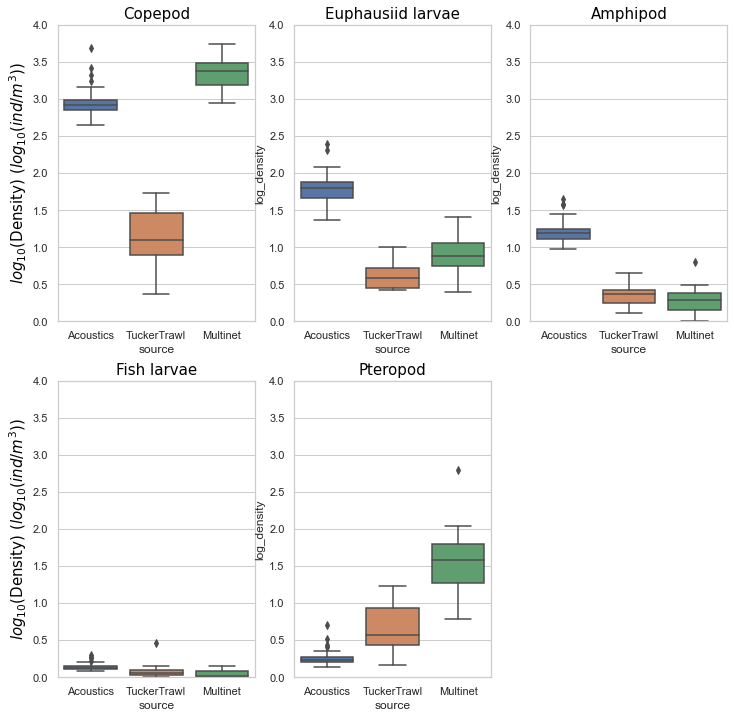

In [55]:
fig = plt.figure(figsize=(12,12))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    
